# Explore GAA2 Data

The second Global Amphibian Acessment (GAA2) completed in June 2022 and acesses 8,011 species aswell as backcasting redlist categorization for 1980 and 2004. 

**An overview of the IUCN Red List criteria**
<img src="images/redlist_criteria_2022.png" >

*For explanations of terms and concepts in this summary, see: IUCN Standards and Petitions Committee. 2022. Guidelines for Using the IUCN Red List Categories and Criteria. Version 15.1. Prepared by the Standards and Petitions Committee. Downloadable from https://www.iucnredlist.org/documents/RedListGuidelines.pdf*

For extinction risk modeling based on geographic ranges, the **criteria B and E** might be especially interesting. However, it is important to note that red list categorizations are based on a complicated process that may not fully be representable by a simple model. 

In [6]:
import pandas as pd
import numpy as np
import geopandas as gpd
import xarray as xr
import rioxarray as rxr
from rasterio.features import rasterize

# plotting
import matplotlib.pyplot as plt
import contextily as ctx
import shapely.geometry as geom

In [59]:
# load spacial data 
gaa2 = gpd.read_file('../Data/GAA2/GAA2_allspecies.gdb', rows=20)

20

In [5]:
gdf_i = gaa2.iloc[[4]]
type(gdf_i['geometry'].iloc[0])

shapely.geometry.multipolygon.MultiPolygon

In [ ]:
gaa2_categories = pd.read('../Data/GAA2/All_amphibians_tabular_data.csv')

# Explore Human Preassure maps

In [49]:
# load urban areas, cropland pastures
urban = xr.open_dataset("../Data/HYDE_landuse_pop_1901_2021/landuse-urbanareas_histsoc_annual_1901_2021.nc", decode_coords="all", decode_times=False)
crop = xr.open_dataset("../Data/HYDE_landuse_pop_1901_2021/landuse-totals_histsoc_annual_1901_2021.nc", decode_coords="all", decode_times=False)
pasture = xr.open_dataset("../Data/HYDE_landuse_pop_1901_2021/landuse-pastures_histsoc_annual_1901_2021.nc", decode_coords="all", decode_times=False)

# normalize the years 1901 - 2021
urban['time'] = (urban['time'] + 1901 - pasture['time'][0]).astype(int)
crop['time'] = (crop['time'] + 1901 - pasture['time'][0]).astype(int)
pasture['time'] = (pasture['time'] + 1901 - pasture['time'][0]).astype(int)

# write crs WSG 84 (lon, lat)
urban = urban.rio.write_crs("EPSG:4326")
crop = crop.rio.write_crs("EPSG:4326")
pasture = pasture.rio.write_crs("EPSG:4326")

In [57]:
# load population data
pop = xr.open_dataset('../Data/HYDE_landuse_pop_1901_2021/population_histsoc_30arcmin_annual_1901_2021.nc')
pop = pop.rio.write_crs("EPSG:4326")
# take the logp1 of the population
pop['total-population'] = np.log(pop['total-population'] + 1)


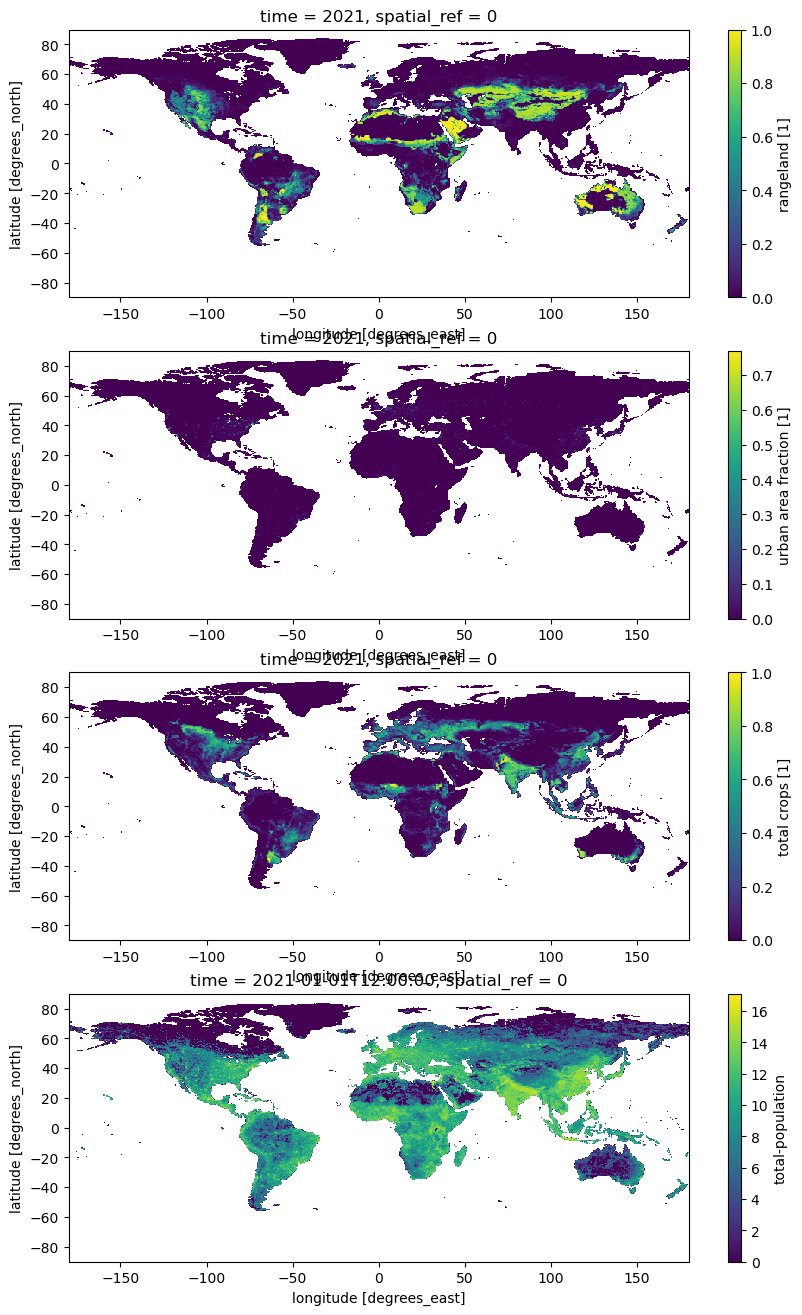

In [58]:
# plot 2021

%matplotlib inline
plt.figure(figsize=(10,16))
plt.subplot(4,1,1)
pasture.sel(time=2021).rangeland.plot.imshow(cmap='viridis', add_colorbar=True)
plt.subplot(4,1,2)
urban.sel(time=2021).urbanareas.plot.imshow(cmap='viridis', add_colorbar=True)
plt.subplot(4,1,3)
crop.sel(time=2021).cropland_total.plot.imshow(cmap='viridis', add_colorbar=True)
plt.subplot(4,1,4)
pop['total-population'].sel(time=pop['time.year']==2021)[0,:,:].plot.imshow(cmap='viridis', add_colorbar=True)

# ERA 5 Data

In [3]:
import pandas as pd
import numpy as np
import geopandas as gpd
import xarray as xr
import rioxarray as rxr
from rasterio.features import rasterize
from datetime import date, timedelta

# plotting
import matplotlib.pyplot as plt
import contextily as ctx

In [4]:
# load and preprocess ERA5 data

# load ERA5 data
ERA5 = xr.open_dataset('../Data/ERA5/ERA5_temp_prec_wind_veg_1980_2023.nc')

# convert to -180, 180 longiude
ERA5['longitude'] = (ERA5['longitude'] + 180) % 360 - 180
ERA5 = ERA5.sortby('longitude')

# put latitude in correct order (-90 to 90) instead of other way around
ERA5 = ERA5.sel(latitude=ERA5['latitude'][::-1])

# write crs
ERA5 = ERA5.rio.write_crs("EPSG:4326")

In [ ]:
# take 1980 - 2000 mean
start_date = date(1960, 1, 1)
end_date = date(1980, 12, 31)
ERA5_1980_2000 = ERA5.sel(time=slice(start_date, end_date))
ERA5_1980_2000_mean = ERA5_1980_2000.mean(dim='time')

In [ ]:
# subtract 273.15 from tas variable
ERA5_1980_2000_mean['tas'] = ERA5_1980_2000_mean['tas'] - 273.15

In [56]:
from utilities_spacial_vars import prep_for_gridcalc
tavg_window, geo_mask, cell_coefs = prep_for_gridcalc(ERA5_1980_2000_mean.tp[0], gaa2.iloc[[4]], margin=4)

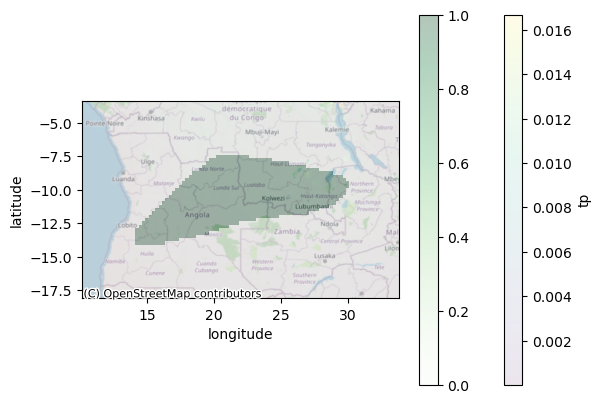

In [65]:
fig, ax = plt.subplots()
bounds = [tavg_window.longitude.values.min(), tavg_window.longitude.values.max(), tavg_window.latitude.values.min(), tavg_window.latitude.values.max()]
tavg_window.plot(ax=ax,alpha=0.1)
da = xr.DataArray(geo_mask, {'latitude': tavg_window.latitude.values, 'longitude': tavg_window.longitude.values})
ctx.add_basemap(ax=ax, crs=tavg_window.rio.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)
da.plot(ax=ax,alpha=0.3, cmap="Greens")

In [63]:
tavg_window.rio.crs.to_string()

'EPSG:4326'

# Berkeley Climate Data

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import xarray as xr
import rioxarray as rxr
from rasterio.features import rasterize
from datetime import date, timedelta

# plotting
import matplotlib.pyplot as plt
import contextily as ctx
%load_ext autoreload
%autoreload 2

In [2]:
# load and preprocess data 

# load monthly average temperature anomaly from berkeley 
TAVG_monthly = xr.open_dataset("../Data/Berkely_monthly_land/Complete_TAVG_LatLong1.nc")
TMAX_monthly = xr.open_dataset("../Data/Berkely_monthly_land/Complete_TMAX_LatLong1.nc")
TMIN_monthly = xr.open_dataset("../Data/Berkely_monthly_land/Complete_TMIN_LatLong1.nc")

# fix fractional time formate 
def decimal_year_to_date(decimal_year):
    year = int(decimal_year)
    days_in_year = (decimal_year - year) * 365.25
    return pd.to_datetime(f"{year}-01-01") + pd.to_timedelta(days_in_year, unit='D')

# bring avg, min max to same time langth
start_date = TMAX_monthly.time.values[0]
end_date = TMAX_monthly.time.values[-1]
TAVG_monthly = TAVG_monthly.sel(time=slice(start_date, end_date))

# update time coordinate 
TAVG_monthly['time'] = [decimal_year_to_date(t) for t in TAVG_monthly.time.values]
TMAX_monthly['time'] = [decimal_year_to_date(t) for t in TMAX_monthly.time.values]
TMIN_monthly['time'] = [decimal_year_to_date(t) for t in TMIN_monthly.time.values]

# for absolute temperature, add climatology to each month.
months = np.array([date.dt.month for date in TAVG_monthly.time])
tavg = TAVG_monthly.temperature.values + TAVG_monthly.climatology.values[months-1]
tmax = TMAX_monthly.temperature.values + TMAX_monthly.climatology.values[months-1]
tmin = TMIN_monthly.temperature.values + TMIN_monthly.climatology.values[months-1]

# Create the data arrays for tavg, tmax, and tmin
tavg = xr.DataArray(tavg, coords=TAVG_monthly.coords, dims=TAVG_monthly.temperature.dims, name='tavg')
tmax = xr.DataArray(tmax, coords=TMAX_monthly.coords, dims=TMAX_monthly.temperature.dims, name='tmax')
tmin = xr.DataArray(tmin, coords=TMIN_monthly.coords, dims=TMIN_monthly.temperature.dims, name='tmin')

# Concatenate the data arrays into a single dataarray
T = xr.merge([tavg, tmax, tmin])

# write crs to WG84 lon,lat
T = T.rio.write_crs("EPSG:4326")

### Example: Calc Mean annual temperature
Also check if quantiles can be blausibly calculated

In [3]:
#
MAT = T.tavg.groupby('time.year').mean('time')
MAT_1940_1970 = MAT.sel(year=slice(1940,1970)).mean('year')
MAT_1980_2004 = MAT.sel(year=slice(1980,2004)).mean('year')
MAT_2004_2023 = MAT.sel(year=slice(2004,2023)).mean('year')

In [8]:
from utilities_spacial_vars import prep_for_gridcalc, weighted_percentile, calc_percentiles
idx = 2
MAT_window, geo_mask, cell_coefs = prep_for_gridcalc(MAT_1940_1970, gaa2.iloc[[idx]])

# using the values calculated above
percentiles = calc_percentiles([5, 50, 95], MAT_1940_1970, gaa2.iloc[[idx]], geo_mask=geo_mask, cell_coefs=cell_coefs)

# from bottom up
percentiles = calc_percentiles([5, 50, 95], MAT_1940_1970, gaa2.iloc[[idx]])

In [11]:
val = MAT_window.values
w = cell_coefs.values

percentile5 = np.sum(w[val<percentiles[0]]) / np.sum(w)
percentile50 = np.sum(w[val<percentiles[1]]) / np.sum(w)
percentile95 = np.sum(w[val<percentiles[2]]) / np.sum(w)

# plot 
fig, ax = plt.subplots(1,2, figsize=(12,4))
MAT_window.plot(ax=ax[0], cmap='bwr')
da = xr.DataArray(geo_mask, {'latitude': MAT_window.latitude.values, 'longitude': MAT_window.longitude.values})
da.plot(ax=ax[0],alpha=0.8, cmap="Greens")
ax[0].set_title('Species range (green) & MAT (blue-red)')

f = ax[1].hist(val, weights=w)
# f = ax[1].scatter(percentiles, np.zeros(3),color='gray', marker='|', s=1000000)
for i, percentile in enumerate(percentiles):
    ax[1].axvline(percentiles[i], color='gray', linestyle='--', linewidth=2)
    ax[1].text(percentiles[i], 0, str(np.round(percentile,1)), ha='center', va='bottom', fontsize=12)
f = ax[1].set_title('MAT distribution; true perc: ({}, {}, {})'.format(np.round(percentile5,2), np.round(percentile50,2), np.round(percentile95,2)))
f = ax[1].set_xlabel('MAT in °C')
f = ax[1].set_ylabel('Area in arbitrary units')


AttributeError: 'numpy.ndarray' object has no attribute 'values'

# Compare temperature consistency of berkeley earth data and ERA5.

In [209]:
# global correlation mean T 1980 - 2020
T_ERA5 = ERA5.t2m.sel(time=slice(date(1980,1,1), date(2000,12,31))).mean(dim='time') - 273.15
T_Berk = T.tavg.sel(time=slice(date(1980,1,1), date(2000,12,31))).mean(dim='time')

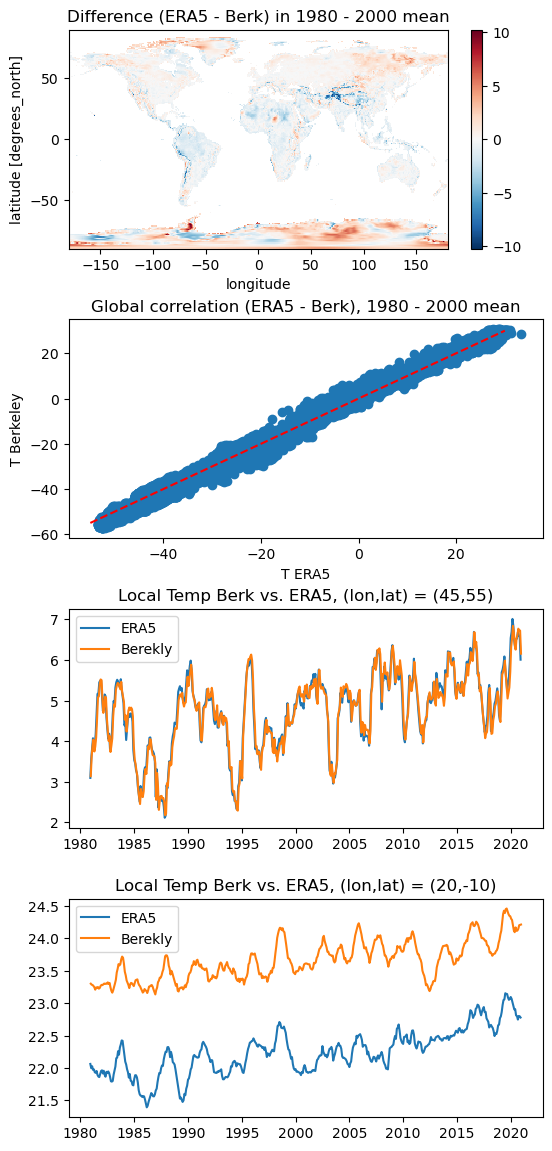

In [258]:
# compare temperature consistency of berkeley earth data and ERA5.
fig, ax = plt.subplots(4,1, figsize=(6,12))
fig.tight_layout(pad=3)


T_ERA5_selected = T_ERA5.sel(latitude = T_Berk.latitude, longitude = T_Berk.longitude, method='nearest')[0].where(~T_Berk.isnull())
T_diff = T_ERA5_selected - T_Berk
T_diff.plot(ax=ax[0])
ax[0].set_title('Difference (ERA5 - Berk) in 1980 - 2000 mean')

ax[1].scatter(T_ERA5_selected.values, T_Berk.values)
ax[1].plot(np.arange(-55,35,5), np.arange(-55,35,5),color='r', ls='--')
ax[1].set_xlabel('T ERA5')
ax[1].set_ylabel('T Berkeley')
ax[1].set_title('Global correlation (ERA5 - Berk), 1980 - 2000 mean')

# (from 1980 to 2020)
lonobs = 45
latobs = 55
T_ERA5_pt = ERA5.t2m.sel(time=slice(date(1980,1,1), date(2020,12,31))).sel(
    longitude=lonobs, latitude=latobs).rolling(time=12).mean() - 273.15
T_Berk_pt = T.tavg.sel(time=slice(date(1980,1,1), date(2020,12,31))).sel(
    longitude=lonobs, latitude=latobs, method='nearest').rolling(time=12).mean()
ax[2].plot(T_ERA5_pt.time, T_ERA5_pt.values[:,0], label='ERA5')
ax[2].plot(T_Berk_pt.time,T_Berk_pt.values, label='Berekly')
ax[2].set_title('Local Temp Berk vs. ERA5, (lon,lat) = ({},{})'.format(lonobs, latobs))
ax[2].legend()


# (from 1980 to 2020)
lonobs = 20
latobs = -10
T_ERA5_pt = ERA5.t2m.sel(time=slice(date(1980,1,1), date(2020,12,31))).sel(
    longitude=lonobs, latitude=latobs).rolling(time=12).mean() - 273.15
T_Berk_pt = T.tavg.sel(time=slice(date(1980,1,1), date(2020,12,31))).sel(
    longitude=lonobs, latitude=latobs, method='nearest').rolling(time=12).mean()
ax[3].plot(T_ERA5_pt.time, T_ERA5_pt.values[:,0], label='ERA5')
ax[3].plot(T_Berk_pt.time, T_Berk_pt.values, label='Berekly')
ax[3].set_title('Local Temp Berk vs. ERA5, (lon,lat) = ({},{})'.format(lonobs, latobs))
ax[3].legend()


# !!! Always double check resampling !!! This one does not work.
from rasterio.enums import Resampling
T_ERA5_dnsampled = T_ERA5.rio.reproject(
    T_ERA5.rio.crs,
    shape=(T_Berk.rio.height, T_Berk.rio.width),
    resampling=Resampling.bilinear,)
# !!!

It seems that there are quite big spacial differences in temperatures between the two datasets. In particular, ERA5 estimates much higher temperatures for high latitudes and much lower temperatures for lower latitudes, compared to the Berkely earth reconstruction.

The ERA5 reconstruction is the more reliable source. Since the monthly mean of max daily temperatures is not included in the monthly average dataset. I will use the berkely earth data for now and derive these quantities from daily data later on.

# Raster spacial Data

In [4]:
# script_test = pd.read_csv('gaa2_landuse_2021.csv')

here :  0.0223202300139491


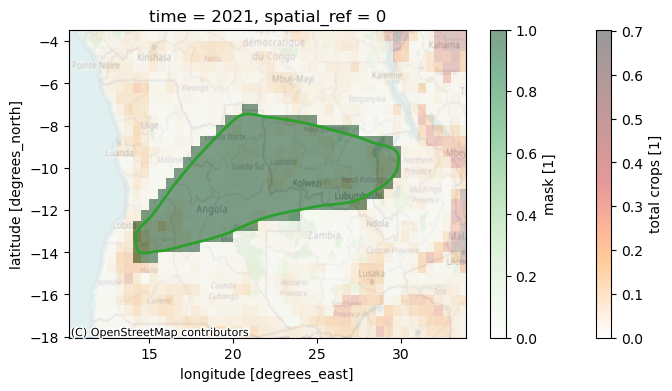

In [8]:
idx = 4
# load test geometry
geo = gaa2.iloc[[idx]]

# get the fractional cropland cover for the window of the geometry
margin = 4
xmin, ymin, xmax, ymax = geo.bounds.values[0]
xmin -= margin
ymin -= margin
xmax += margin
ymax += margin

crop21 = crop.sel(time=2021).cropland_total
dat_window = crop21.sel(lon = slice(xmin, xmax), lat = slice(ymax, ymin))

# Rasterize the polygon according to window
poly = geo['geometry'].iloc[0]
poly_mask = rasterize([(poly)],
                transform=dat_window.rio.transform(),
                out_shape=dat_window.shape, 
                all_touched=True)


# calculate the percentage of range size covered by crops
## weight data cells by grid cell size
from numpy import pi, cos

dat_window = dat_window.fillna(0)
lats = np.expand_dims(dat_window.lat,axis=1) / 360 * 2 * pi
cell_coefs = cos(lats)
dat_wheighted = dat_window.values * cell_coefs

## perform calculation
cropcover_percentage = np.sum(poly_mask * dat_wheighted) / np.sum(poly_mask * cell_coefs)

print('here : ', cropcover_percentage)
# print('script: ', script_test.cropland_2021.iloc[idx])



# Visualize
## copy array to xarray with appropiate coordinates and crs (improvised version)
mask2 = dat_window.copy()
mask2.attrs['long_name'] = 'mask'
mask2.values = poly_mask

## plot
fig, ax = plt.subplots(figsize=(8,4))
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
geo.plot(ax=ax, facecolor='none', edgecolor='tab:green', linewidth=2)
ctx.add_basemap(ax=ax, crs=geo.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)
dat_window.plot.imshow(ax=ax, alpha = 0.4, cmap='gist_heat_r')
mask2.plot.imshow(ax=ax, alpha= 0.5, cmap='Greens')